Author: [@SauravMaheshkar](https://github.com/SauravMaheshkar)

# 👁 Introducing Quickvision

**Quickvision** is a Computer Vision Library built on Top of Torchvision, PyTorch and Lightning

It provides: -

1. Easy to use PyTorch native API, for `fit()`, `train_step()`, `val_step()` of models.
2. Easily customizable and configurable models with various backbones.
3. A complete PyTorch native interface. All models are `nn.Module`, all the training APIs are optional and not binded to models.
4. A lightning API which helps to accelerate training over multiple GPUs, TPUs.
5. A datasets API to convert common data formats very easily and quickly to PyTorch formats.
6. A minimal package, with very low dependencies.


### Quickvision is just PyTorch!!
---

- Quickvision does not make you learn a new library. If you know PyTorch, you are good to go!!!
- Quickvision does not abstract any code from PyTorch, nor implements any custom classes over it.
- It keeps the data format in `Tensor` so that you don't need to convert it.


### Do you want just a model with some backbone configuration?
---
- Use model made by us. It's just a `nn.Module` which has Tensors only Input and Output format.
- Quickvision provides reference scripts too for training it!



### Do you want to train your model but not write lengthy loops?
---
- Just use our training methods such as `fit()`, `train_step()`, `val_step()`.



### Do you want multi GPU training but worried about model configuration?
---
- Just subclass the PyTorch Lightning model! 
- Implement the `train_step()`, `val_step()`.

Quickvision is currently on release 0.1.0, we have provided training APIs for detection as well as classification tasks.

* Supported some torchvision CNNs training.
* Supported Detection models from torchvision Faster RCNN and Retina Net .
* Supported DETR (Detection Transformers) for Object detection transfer learning through torch.hub 
* Supports Some backbones which can be trained through CNN Trainer.
* Supported Pretrained weights other than imagenet for few models.
* Have Sanity Fit APIs for all the above models.
* PyTorch Lightning trainers for all above.
* Added lot of tutorials and notebooks for users to learn. We hope you get the feel of library and use it.

Thanks to our awesome contributors [@hassiahk](https://github.com/hassiahk) and [@ramaneswaran](https://github.com/ramaneswaran) for helping in this release.

We'll also use Weights and Biases for Logging.

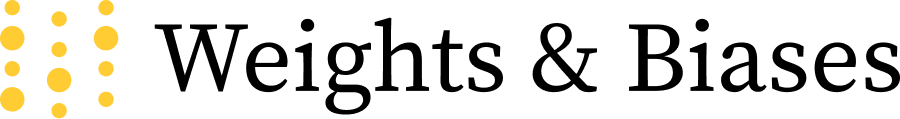

[Weights & Biases](https://wandb.com/) is a machine learning experiment tracking, dataset versioning, and project collaboration tool.

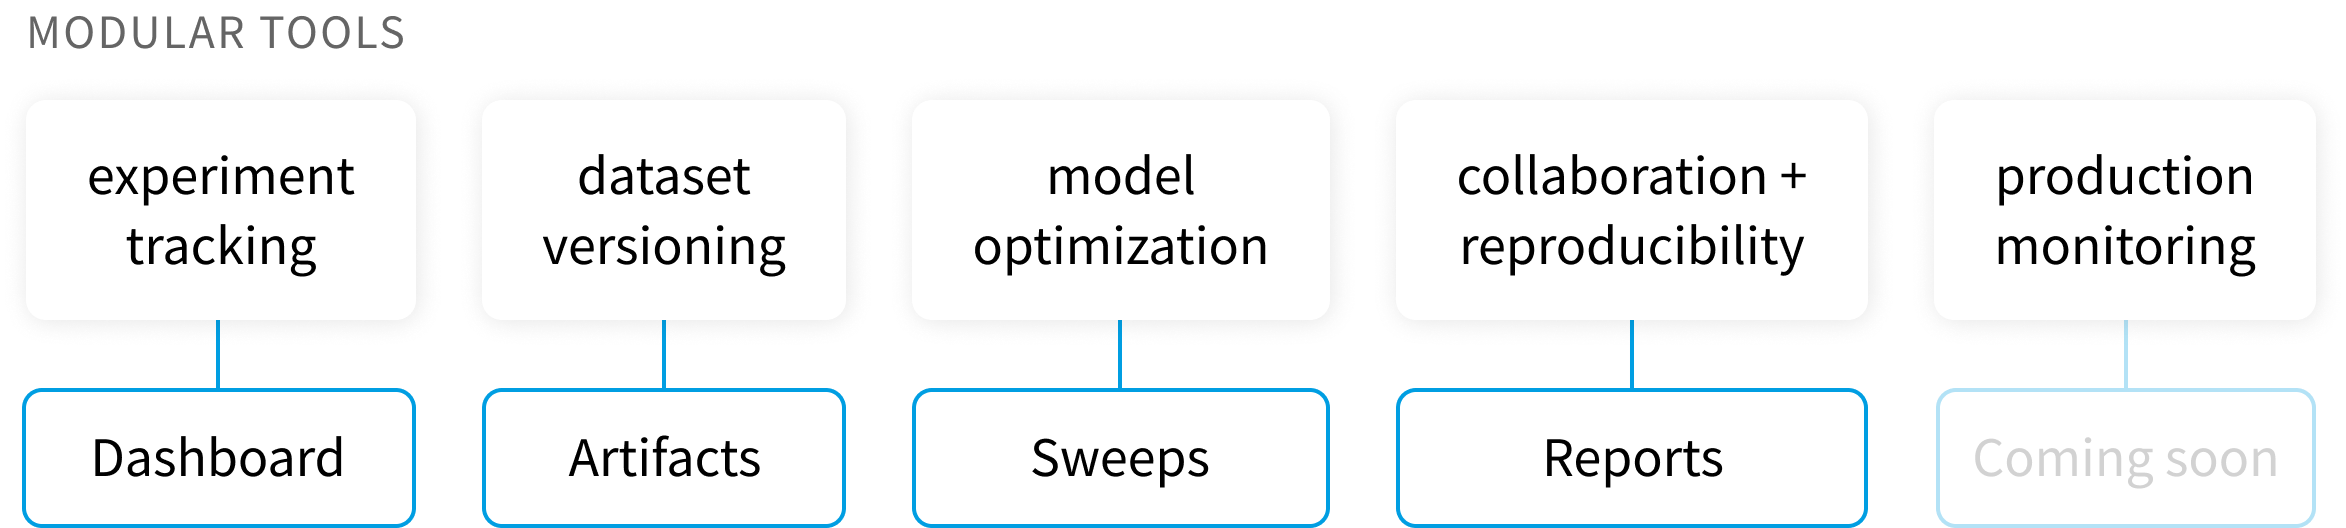

## We'll show you how:-

1. Quickvision allows you to bring your own `Dataset`, `Model` or `Code` Recipe

2. You may use models, training functions or Dataset loading utilites from quickvision.

3. Seamless API to connect with Lightning as well.

4. Faster Experimentation with same control with PyTorch or Lightning.

5. Using the `wandb.log` API to log metrics.

Visit us [here](https://github.com/Quick-AI/quickvision) over GitHub !

We are happy for new contributions / improvements to our package.

Quickivison is a library built for faster but doesn't compromise PyTorch Training !

# 🚀 Install, Import and Login

For this tutorial, we'll use the [WideResnet](https://arxiv.org/abs/1605.07146) model (included in the 0.2.0rc1 version). You can download the stable version of the library using 

```
pip install quickvision
```

The current stable release `0.1` requires `PyTorch 1.7` and `torchvision 0.8.1`

In [1]:
%%capture
!python -m pip install git+https://github.com/Quick-AI/quickvision.git
!pip install wandb --upgrade

In [2]:
import random
import torch
import numpy as np

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
import pytorch_lightning as pl

# Our hero!!
import quickvision

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In order to log data to wandb, you'll need to log in.

If this is your first time using W&B, you'll need to sign up for a free account at the link that appears.

In [ ]:
import wandb

wandb.login()

# 👷🏻‍♂️ Define Data Loading and the Model

Quickivision is not binded to any library for transforms. Let's keep it simple and use torchvision transforms for now.

In [7]:
# Train and validation Transforms which you would like
train_transforms = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
valid_transforms = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])

We'll use the `cifar10` dataset for this tutorial using the [`torchvision.datasets.CIFAR10()`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.CIFAR10) function

In [8]:
%%capture
train_set = torchvision.datasets.CIFAR10("./data", download=True, train=True, transform=train_transforms)
valid_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=valid_transforms)

In [9]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Quickvision Provides simple functions to create models with pretrained weights.

In [ ]:
from quickvision.models.classification import cnn

# To create model with imagenet pretrained weights 
model = cnn.create_vision_cnn("wide_resnet50_2", num_classes=10, pretrained="imagenet")

# Alternatively if you don't need pretrained weights
# model_bare = cnn.create_vision_cnn("resnet50", num_classes=10, pretrained=None)

# It also supports other weights, do check a list which are supported !
# model_ssl = cnn.create_vision_cnn("resnet50", num_classes=10, pretrained="ssl")

Just like in torch we define the criterion and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 💪🏻 Training the Model

Instead of doing something like 

```
model = model.to(device)
for epoch in range(2):
    for batch_idx, (inputs, target) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
```

Quickvision already implements these boring procedures for you to speed up training !

You can use the `.fit()` method as shown to train the model using a single line of code !!

```
history = cnn.fit(model=model, epochs=2, train_loader=train_loader,
        val_loader=valid_loader, criterion=criterion, device=device, optimizer=optimizer)
```

If you prefer more granular control you can use our `train_step()` and `val_step()` methods. We calculate commonly used metrics such as accuracy here for you.

In [ ]:
wandb.init(project="intro-to-quickvision")

for epoch in tqdm(range(5)):
    print()
    print(f"Training Epoch = {epoch}")
    train_metrics = cnn.train_step(model, train_loader, criterion, device, optimizer)
    print()
    wandb.log({"Training Top1 acc": train_metrics["top1"], "Training Top5 acc": train_metrics["top5"], "Training loss": train_metrics["loss"]})

    print(f"Validating Epoch = {epoch}")
    valid_metrics = cnn.val_step(model, valid_loader, criterion, device)
    print()
    wandb.log({"Validation Top1 acc": valid_metrics["top1"], "Validation Top5 acc": valid_metrics["top5"], "Validation loss": valid_metrics["loss"]})

You can also train with Lightning!

* We have the same logics implemented for PyTorch Lightning as well.
* This directly allows you to use all Lighning features such as Multi-GPU training, TPU Training, logging etc.

Quickly Prototype with Torch, transfer it to Lightning !

```
model_imagenet = cnn.lit_cnn("resnet18", num_classes=10, pretrained="imagenet")

gpus = 1 if torch.cuda.is_available() else 0

# Again use all possible Trainer Params from Lightning here !!
trainer = pl.Trainer(gpus=gpus, max_epochs=2)
trainer.fit(model_imagenet, train_loader, valid_loader)
```

# 🔖 Save the Model

In [ ]:
torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))
torch.onnx.export(model, images, "model.onnx")
wandb.save("model.onnx")

# 📄 Some More Features of Quickvision

Currently Supported Models are listed below.

### Classification

* Resnet: - Resnet18, Resnet34, Resnet50, Resnet101, Resnet152, ResNext

* VGG: - VGG13, VGG16, VGG19

* Mobilenet_v2

* MNASNet:- MnasNet 0_5, MnasNet 0_75, MnasNet 1_0, MnasNet 1_3

### Detection

* Detr From FaceBook Detr, using torch.hub

* RetinaNet From Torchvision

* FasterRCNN From Torchvision.